# Projet 6 : Classifiez automatiquement des biens de consommation

Notebook de traitement du texte et des images et de tests de différentes méthodes de clustering


# Summary
 - <a href="#C1">Import and settings</a>
      - <a href="#C1.1">Import required items</a>
      - <a href="#C1.2">Settings</a>
 - <a href="#C2">Functions</a>
 - <a href="#C3">Data analysis and cleaning</a>
      - <a href="#C3.1">Focus on Product Category</a>
      - <a href="#C3.2">Prepare text data</a>
 - <a href="#C4">Clustering from text data</a>
      - <a href="#C4.1">Bag of Words - Tf-idf</a>
      - <a href="#C4.2">Word2Vec</a>
      - <a href="#C4.3">BERT</a>
      - <a href="#C4.4">USE - Universal Sentence Encoder</a>
 - <a href="#C5">Clustering from images</a>
      - <a href="#C5.1">Settings and data preparation</a>
      - <a href="#C5.2">SIFT</a>
      - <a href="#C5.3">CNN</a>
 - <a href="#C6">Classification engine</a>

# <a name="C1"> Import and settings
## <a name="C1.1"> Import required items

In [1]:
# Use code formatting tool
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import required librairies
import os, datetime
import multiprocessing

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import words, stopwords

from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
)
from sklearn.model_selection import train_test_split

import gensim

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow_hub as hub
from tensorflow_estimator.python.estimator.canned.dnn import dnn_logit_fn_builder

from keras.layers import Dense
from keras import Model
from keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input

import transformers
from transformers import TFAutoModel, AutoTokenizer

import cv2
from PIL import Image

<IPython.core.display.Javascript object>

In [3]:
# Import data from file in a DataFrame
data_products = pd.read_csv(
    "C:/Users/bruno/kDrive/Work/OpenClassrooms/P6/Flipkart/flipkart_com-ecommerce_sample_1050.csv"
)
print(data_products.shape)

(1050, 15)


<IPython.core.display.Javascript object>

## <a name="C1.2"> Settings

In [4]:
# Set the results display
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 100)
pd.options.display.float_format = "{:,.4f}".format

<IPython.core.display.Javascript object>

In [5]:
# General settings
random_set = 42
# Keras setting
os.environ["TF_KERAS"] = "1"

<IPython.core.display.Javascript object>

# <a name="C2"> Functions

In [6]:
# Manage text
def display_tokens_info(tokens):
    """
    Display information about corpus:
    Number of tokens, number of unique tokens and the first 30 tokens

    """

    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])

<IPython.core.display.Javascript object>

In [7]:
# Manage text
def process_text(
    doc,
    rejoin=False,
    lemm_or_stemm="stem",
    list_rare_words=None,
    min_len_word=3,
    force_is_alpha=True,
    eng_words=None,
    extra_words=None,
):
    """
    Function for text processing and create cleaned tokens

    Parameters
    ----------
    doc : string, initial text we want to process
    rejoin : bool, True to join the tuple data into 1 string
    lemm_or_stemm : "lem" or "stem", choose the lemming or stemming method to be applied
    list_rare_words : list, words we exclude because they are too rare
    min_len_word : int, minimum size of words we want to keep
    force_is_alpha : bool, True to remove figures
    eng_words : list, to compare with our tokens list and keep only the ones existing in this list of English words
    extra_words : list, words we exclure because they appears too many times

    Return
    ------
    Processed tokens

    """

    # list unique words
    if not list_rare_words:
        list_rare_words = []

    # list of extra words
    if not extra_words:
        extra_words = []

    # lower
    doc = doc.lower().strip()

    # tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # stop words
    cleaned_token_list = [w for w in raw_tokens_list if w not in stop_words]

    # no rare tokens
    non_rare_tokens = [w for w in cleaned_token_list if w not in list_rare_words]

    # no more len words
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # only alpha chars
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = more_than_N

    # lemmer or stemmer
    if lemm_or_stemm == "stem":
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    else:
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]

    # in english
    if eng_words:
        engl_text = [i for i in trans_text if i in eng_words]
    else:
        engl_text = trans_text

    # drop extra words tokens
    final = [w for w in engl_text if w not in extra_words]

    # manage return type
    if rejoin:
        return " ".join(final)

    return final

<IPython.core.display.Javascript object>

In [8]:
# Manage text
def final_clean(doc):
    """
    Perform final cleaning on the text data using specific parameters for process_text function

    Parameters
    ----------
    doc : string, initial text we want to process

    Return
    ------
    Processed tokens joined

    """

    new_doc = process_text(
        doc,
        rejoin=True,
        lemm_or_stemm="stem",
        list_rare_words=list_unique_words,
        min_len_word=3,
        force_is_alpha=True,
        eng_words=eng_words_stem,
        extra_words=freq_words,
    )

    return new_doc

<IPython.core.display.Javascript object>

In [9]:
# Identify clusters, evaluate them with ARI and display data on a projected 2D TSNE
def ARI_fct(features):
    """
    Calculate TSNE projection, identify clusters on it using k-means,
    and evaluate the cluster by comparing their values with the real categories.

    Parameters
    ----------
    features : 2D matrix

    Return
    ------
    ARI : Asjusted Rand Index value of comparison between predicted clusters and real categories
    X_tsne : projected datza using TSNE
    cls.labels_ : clusters labels

    """

    # identify the number of clusters (= number of categories)
    num_labels = len(l_cat)

    # calculate tsne projection data
    tsne = manifold.TSNE(
        n_components=2,
        perplexity=30,
        n_iter=2000,
        init="random",
        learning_rate=200,
        random_state=random_set,
    )
    X_tsne = tsne.fit_transform(features)

    # Identify clusters based on data after TSNE calculation and evaluate with ARI
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=random_set)
    cls.fit(X_tsne)

    # evaluate the clusters
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    print("ARI : ", ARI)

    return ARI, X_tsne, cls.labels_


def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI):
    """
    Display twice the TSNE projection
    1. colored with real categorie
    2. colored with the predicted clusters

    And print the ARI for the clustering

    Parameters
    ----------
    X_tsne : projected data using TSNE
    y_cat_num : real categories
    labels : cluster labels
    ARI : precalculated ARI for these clusters

    Return
    ------
    plot : tsne projection colored with real categorie VS tsne projection colored by clusters
    ARI : Asjusted Rand Index value of comparison between predicted clusters and real categories
    """

    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=l_cat,
        loc="best",
        title="Categorie",
    )
    plt.title("Représentation des descriptions par catégories réelles")

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(labels),
        loc="best",
        title="Clusters",
    )
    title_cluster = "Représentation des descriptions par clusters " + method
    plt.title(title_cluster)

    plt.show()
    print("ARI : ", ARI)

<IPython.core.display.Javascript object>

In [10]:
# Prepare sentences for BERT process
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    """Prepare data for BERT process"""

    # Initiate our outputs as lists
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    # create tokens from each sentence
    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding="max_length",
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True,
            return_tensors="tf",
        )

        input_ids.append(bert_inp["input_ids"][0])
        token_type_ids.append(bert_inp["token_type_ids"][0])
        attention_mask.append(bert_inp["attention_mask"][0])
        bert_inp_tot.append(
            (
                bert_inp["input_ids"][0],
                bert_inp["token_type_ids"][0],
                bert_inp["attention_mask"][0],
            )
        )

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Create features from sentences using BERT model
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode="HF"):
    """
    Create features using BERT model

    Parameters
    ----------
    model : loaded BERT model
    model_type : name of the model
    sentences : list of sentences to process
    max_length : maximum length (in number of tokens) for the inputs
    b_size : number of tokens to be considered as a group
    mode : "HF" for HuggingFace, "TFhub" for Tensorflow Hub

    Return
    ------
    features_bert : 2D matrix

    """

    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)

    for step in range(len(sentences) // batch_size):
        idx = step * batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(
            sentences[idx : idx + batch_size], bert_tokenizer, max_length
        )

        if mode == "HF":  # Bert HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred
            )
            last_hidden_states = outputs.last_hidden_state

        if mode == "TFhub":  # Bert Tensorflow Hub
            text_preprocessed = {
                "input_word_ids": input_ids,
                "input_mask": attention_mask,
                "input_type_ids": token_type_ids,
            }
            outputs = model(text_preprocessed)
            last_hidden_states = outputs["sequence_output"]

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states)
            )

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    return features_bert

<IPython.core.display.Javascript object>

In [11]:
# Create features from sentences using USE model
def feature_USE_fct(sentences, b_size):
    """
    Create features using USE model

    Parameters
    ----------
    sentences : list of sentences to process
    b_size : number of tokens to be considered as a group

    Return
    ------
    features : 2D matrix
    """

    batch_size = b_size

    for step in range(len(sentences) // batch_size):
        idx = step * batch_size
        feat = embed(sentences[idx : idx + batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    return features

<IPython.core.display.Javascript object>

In [12]:
# Preprocess the pictures
def prepare_image(picture):
    """
    Prepare the image in order to ne processed by a Convolutional Neural Network (CNN) model

    Parameters
    ----------
    picture : name of the picture file

    Return
    ------
    img : 3D matrix for each image

    """
    img = load_img(
        path + picture,
        target_size=dim,
    )
    img = img_to_array(img)
    img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
    img = preprocess_input(img)

    return img

<IPython.core.display.Javascript object>

In [13]:
# Identify features from an image using sift method
def features_sift(picture):
    """3D matrix for each image
    Create features from an image using sift method

    Parameters
    ----------
    picture : name of the picture file

    Return
    ------
    features : 2D matrix for each image

    """
    # load the pictures
    img = cv2.imread(path + picture)
    # Resize the pictures so they have the same size
    img = cv2.resize(img, dim)

    img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
    # Tranform the pictures to grey
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # create the keypoints and descriptors
    keypoints = sift.detect(img, None)[:size]
    keypoints, descriptors = sift.compute(img, keypoints)

    # manage missing descriptors
    if descriptors is not None:
        if len(descriptors) >= size:
            features = descriptors
        else:
            features = np.NaN
    else:
        features = np.NaN

    return features

<IPython.core.display.Javascript object>

In [14]:
def pca_data(X):
    """Function that reduces data dimensions using PCA method"""

    print("Initial shape of data : ", X.shape)
    X_std = X

    # Components number - first try
    n_comp = int(round(min(X_std.shape[0], X_std.shape[1] * 0.5), 0))

    # Calculate Principal Components
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(X_std)

    # Set the relevant number of components (explain 95% of the variance)
    c = 1
    while pca.explained_variance_ratio_[0:c].cumsum()[-1] < 0.95:
        c += 1

    # Calculate Principal Components with relevant number of components
    pca = decomposition.PCA(n_components=c)
    X_reduced = pca.fit_transform(X_std)
    print("Reduced data shape :", X_reduced.shape)
    return X_reduced

<IPython.core.display.Javascript object>

# <a name="C3"> Data analysis

In [15]:
# Start date and time of the notebook calculation
start = datetime.datetime.now()

<IPython.core.display.Javascript object>

In [16]:
# Look at the shape and first lines of the data
print(data_products.shape)
data_products.head(5)

(1050, 15)


uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0    1,899.0000          899.0000  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1      600.0000          449.0000  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3    2,699.0000        1,299.0000  d4684dcdc759dd9cdf41504698d737d8.jpg   
4    2,599.0000          698.0000  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

<IPython.core.display.Javascript object>

In [17]:
# look at the last lines of the data
data_products.tail(5)

uniq_id            crawl_timestamp  \
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
1045    1,399.0000          999.0000  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046    4,930.0000        1,896.0000  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047    4,500.0000        1,449.0000  5912e037d12774bb73a2048f35a00009.jpg   
1048    3,465.0000        1,333.0000  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049    1,190.0000          595.0000  f2f027ad6a6df617c9f125173da71e44.jpg   

      is_FK_Advantage_product  \
1045                    False   
1046                    False   
1047                    False   
1048                    False   
1049                    False   

                                            description       product_rating  \
1045  Oren Empower Extra Large Self Adhesive Sticker...  No rating available   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...  No rating available   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...  No rating available   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...  No rating available   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...                    4   

           overall_rating         brand  \
1045  No rating available  Oren Empower   
1046  No rating available    Wallmantra   
1047  No rating available      Uberlyfe   
1048  No rating available    Wallmantra   
1049                    4      Uberlyfe   

                                 product_specifications  
1045  {"product_specification"=>[{"key"=>"Number of ...  
1046  {"product_specification"=>[{"key"=>"Number of ...  
1047  {"product_specification"=>[{"key"=>"Number of ...  
1048  {"product_specification"=>[{"key"=>"Number of ...  
1049  {"product_specification"=>[{"key"=>"Sales Pack...

<IPython.core.display.Javascript object>

In [18]:
# analyze further
data_products.describe(include="all")

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   
mean                                 NaN                        NaN   
std                                  NaN                        NaN   
min                                  NaN                        NaN   
25%                                  NaN                        NaN   
50%                                  NaN                        NaN   
75%                                  NaN                        NaN   
max                                  NaN                        NaN   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/elegance-polyester-mul...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                             product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  CRNEG7BKMFFYHQ8Z   
freq                                                   56                 1   
mean                                                  NaN               NaN   
std                                                   NaN               NaN   
min                                                   NaN               NaN   
25%                                                   NaN               NaN   
50%                                                   NaN               NaN   
75%                                                   NaN               NaN   
max                                                   NaN               NaN   

        retail_price  discounted_price                                 image  \
count     1,049.0000        1,049.0000                                  1050   
unique           NaN               NaN                                  1050   
top              NaN               NaN  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq             NaN               NaN                                     1   
mean      2,186.1973        1,584.5272                                   NaN   
std       7,639.2294        7,475.0997                                   NaN   
min          35.0000           35.0000                                   NaN   
25%         555.0000          340.0000                                   NaN   
50%         999.0000          600.0000       

<IPython.core.display.Javascript object>

In [19]:
# Some data is missing, especially for the brand, but we won't use this field
data_products.isnull().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

<IPython.core.display.Javascript object>

In [20]:
# Check if there are doublons
for col in data_products.columns:
    print(
        col,
        ":",
        len(data_products[data_products.duplicated(subset=[col], keep=False)]),
    )
# image and description have no doublons

uniq_id : 0
crawl_timestamp : 977
product_url : 0
product_name : 0
product_category_tree : 504
pid : 0
retail_price : 818
discounted_price : 758
image : 0
is_FK_Advantage_product : 1050
description : 0
product_rating : 1041
overall_rating : 1041
brand : 659
product_specifications : 80


<IPython.core.display.Javascript object>

## <a name="C3.1"> Focus on Product Category

In [21]:
# Let's have a look at the product categories in order to choose which level we should use
data_products["product_category_tree"].unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

<IPython.core.display.Javascript object>

In [22]:
data_products["product_category_tree"].nunique()

642

<IPython.core.display.Javascript object>

In [23]:
# Split the tree into the different levels
tmp = data_products["product_category_tree"].str.split(" >> ", expand=True)
tmp

0                       1                 2  \
0     ["Home Furnishing  Curtains & Accessories          Curtains   
1           ["Baby Care        Baby Bath & Skin  Baby Bath Towels   
2           ["Baby Care        Baby Bath & Skin  Baby Bath Towels   
3     ["Home Furnishing               Bed Linen         Bedsheets   
4     ["Home Furnishing               Bed Linen         Bedsheets   
...                 ...                     ...               ...   
1045        ["Baby Care       Baby & Kids Gifts          Stickers   
1046        ["Baby Care       Baby & Kids Gifts          Stickers   
1047        ["Baby Care       Baby & Kids Gifts          Stickers   
1048        ["Baby Care       Baby & Kids Gifts          Stickers   
1049        ["Baby Care       Baby & Kids Gifts          Stickers   

                                                      3  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                             Sathiyas Baby Bath Towels   
2                              Eurospa Baby Bath Towels   
3                       SANTOSH ROYAL FASHION Bedsheets   
4                                Jaipur Print Bedsheets   
...                                                 ...   
1045                            Oren Empower Stickers"]   
1046                              Wallmantra Stickers"]   
1047                                Uberlyfe Stickers"]   
1048                              Wallmantra Stickers"]   
1049                                Uberlyfe Stickers"]   

                                                      4     5     6  
0                                                  None  None  None  
1     Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...  None  None  
2     Eurospa Cotton Terry Face Towel Set (20 PIECE ...  None  None  
3     SANTOSH ROYAL FASHION Cotton Printed King size...  None  None  
4     Jaipur Print Cotton Floral King sized Double B...  None  None  
...                                                 ...   ...   ...  
1045                                               None  None  None  
1046                                               None  None  None  
1047                                               None  None  None  
1048                                               None  None  None  
1049                                               None  None  None  

[1050 rows x 7 columns]

<IPython.core.display.Javascript object>

In [24]:
# Lots of products don't have level 3 and more filled in
tmp.isnull().sum()

0      0
1      0
2      3
3    371
4    645
5    923
6    993
dtype: int64

<IPython.core.display.Javascript object>

In [25]:
# Level 0 is the most relevant level, level 1 has too many values
print("Level 0 : ", tmp[0].nunique(), "unique values")
print("Level 1 : ", tmp[1].nunique(), "unique values")
print("Level 2 : ", tmp[2].nunique(), "unique values")

Level 0 :  7 unique values
Level 1 :  63 unique values
Level 2 :  246 unique values


<IPython.core.display.Javascript object>

In [26]:
# Let's look at the level 0 values
tmp[0].unique()

array(['["Home Furnishing', '["Baby Care', '["Watches',
       '["Home Decor & Festive Needs', '["Kitchen & Dining',
       '["Beauty and Personal Care', '["Computers'], dtype=object)

<IPython.core.display.Javascript object>

In [27]:
# Let's look at the level 1 values
tmp[1].unique()

array(['Curtains & Accessories', 'Baby Bath & Skin', 'Bed Linen',
       'Wrist Watches', 'Living Room Furnishing', 'Bath Linen',
       'Candles & Fragrances', 'Tableware & Cutlery', 'Lighting',
       'JMD Home Furnishing', 'Infant Wear', "Kripa's Home Furnishing",
       'Hair Care', 'Coffee Mugs', 'Network Components',
       'Tablet Accessories', 'Cookware', 'Laptop Accessories', 'Makeup',
       'Combos and Kits', 'Feeding & Nursing', 'Baby Bedding',
       'Kitchen & Dining Linen', 'Containers & Bottles',
       'Consumables & Disposables', 'Wall Decor & Clocks',
       'Table Decor & Handicrafts', 'Flowers, Plants & Vases', 'Software',
       'Showpieces', 'Furniture & Furnishings',
       'Decorative Lighting & Lamps', 'Baby Grooming',
       'Computer Peripherals', 'Cushions, Pillows & Covers', 'Storage',
       'Health Care', 'Body and Skin Care', 'Kitchen Tools',
       'TRUE Home Decor & Festive Needs"]', 'Living', 'Showpiece',
       'Bar & Glassware', 'Fragrances', "Wome

<IPython.core.display.Javascript object>

In [28]:
# Most of those categories only appear a few times
tmp[1].value_counts().describe()

count    63.0000
mean     16.6667
std      27.4596
min       1.0000
25%       1.5000
50%       6.0000
75%      15.0000
max     149.0000
Name: 1, dtype: float64

<IPython.core.display.Javascript object>

In [29]:
# while level 0 frequency is balanced
tmp[0].value_counts()

["Home Furnishing               150
["Baby Care                     150
["Watches                       150
["Home Decor & Festive Needs    150
["Kitchen & Dining              150
["Beauty and Personal Care      150
["Computers                     150
Name: 0, dtype: int64

<IPython.core.display.Javascript object>

In [30]:
# Let's add level 0 as a new feature
data_products["_product_category"] = (
    data_products["product_category_tree"].str.split(" >> ", expand=True)[0].str[2:]
)
data_products.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0    1,899.0000          899.0000  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1      600.0000          449.0000  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3    2,699.0000        1,299.0000  d4684dcdc759dd9cdf41504698d737d8.jpg   
4    2,599.0000          698.0000  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications _product_category  
0  {"product_specification"=>[{"key"=>"Brand", "v...   Home Furnishing  
1  {"product_specification"=>[{"key"=>"Machine Wa...         Baby Care  
2  {"product_specification"=>[{"key"=>"Material",...         Baby Care  
3  {"product_specification"=>[{"key"=>"Brand", "v...   Home Furnishing  
4  {"product_specification"=>[{"key"=>"Machine Wa...   Home Furnishing

<IPython.core.display.Javascript object>

## <a name="C3.2"> Prepare text data

In [31]:
# Have a look at a description sample
doc = data_products["description"].sample(1)
doc = str(doc.values[0])
doc

'Tatvaarts Tribal Face Showpiece  -  21.59 cm (Brass, Gold)\r\n                         Price: Rs. 6,100\r\n\t\t\t\t\r\n\t\t\tA nice and beautiful home décor item. Made of cast iron, this product stands out to enjoy a special place in your room. It can also be gifted to your near and dear ones on any eventful day.\r\nA nice and beautiful home décor item. Made of cast iron, this product stands out to enjoy a special place in your room. It can also be gifted to your near and dear ones on any eventful day.'

<IPython.core.display.Javascript object>

In [32]:
# Create tokens from it
tokenizer = RegexpTokenizer(r"\w+")
tokens = tokenizer.tokenize(doc)
display_tokens_info(tokens)

nb tokens 89, nb tokens uniques 48
['Tatvaarts', 'Tribal', 'Face', 'Showpiece', '21', '59', 'cm', 'Brass', 'Gold', 'Price', 'Rs', '6', '100', 'A', 'nice', 'and', 'beautiful', 'home', 'décor', 'item', 'Made', 'of', 'cast', 'iron', 'this', 'product', 'stands', 'out', 'to', 'enjoy']


<IPython.core.display.Javascript object>

In [33]:
# create the list of english stop words
stop_words = set(stopwords.words("english"))
# remove them from our tokens
tokens = [w for w in tokens if w not in stop_words]
display_tokens_info(tokens)

nb tokens 59, nb tokens uniques 36
['Tatvaarts', 'Tribal', 'Face', 'Showpiece', '21', '59', 'cm', 'Brass', 'Gold', 'Price', 'Rs', '6', '100', 'A', 'nice', 'beautiful', 'home', 'décor', 'item', 'Made', 'cast', 'iron', 'product', 'stands', 'enjoy', 'special', 'place', 'room', 'It', 'also']


<IPython.core.display.Javascript object>

In [34]:
# Let's do this on the entire corpus by joining all documents
raw_corpus = " ".join(data_products["description"].values)
raw_corpus[:1000]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

<IPython.core.display.Javascript object>

In [35]:
# Apply our fonction to process the corpus, with removing of stop words, stemming, and removing les than 3 letters'words
corpus = process_text(
    raw_corpus,
    rejoin=False,
    lemm_or_stemm="stem",
    list_rare_words=None,
    min_len_word=3,
    force_is_alpha=True,
    eng_words=None,
    extra_words=None,
)
display_tokens_info(corpus)

nb tokens 52969, nb tokens uniques 4372
['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester']


<IPython.core.display.Javascript object>

In [36]:
# Let's have a look at the distribution of tokens
tmp = pd.Series(corpus).value_counts()
tmp

product     864
free        618
buy         581
delivery    567
genuine     564
           ... 
visit         1
maxim         1
dvd           1
partner       1
deeply        1
Length: 4372, dtype: int64

<IPython.core.display.Javascript object>

In [37]:
# top 30 tokens
tmp.head(30)

product          864
free             618
buy              581
delivery         567
genuine          564
cash             564
shipping         564
price            561
replacement      559
day              553
flipkart         481
com              473
guarantee        471
mug              457
feature          404
online           396
specification    379
color            369
watch            355
type             325
baby             321
pack             319
material         313
set              311
cotton           299
box              297
general          288
design           273
package          269
sale             262
dtype: int64

<IPython.core.display.Javascript object>

In [38]:
# last 30 tokens
tmp.tail(30)

technique       1
portion         1
jaipurcrafts    1
festivity       1
celebration     1
serf            1
ordered         1
reflects        1
auspicious      1
demand          1
termite         1
authorized      1
fone            1
nearby          1
cleanse         1
dune            1
booking         1
hr              1
saco            1
karbonn         1
cancellation    1
gone            1
knock           1
mother          1
assemble        1
visit           1
maxim           1
dvd             1
partner         1
deeply          1
dtype: int64

<IPython.core.display.Javascript object>

In [39]:
# Lots of tokens only appear once
tmp.describe()

count   4,372.0000
mean       12.1155
std        43.6180
min         1.0000
25%         1.0000
50%         2.0000
75%         6.0000
max       864.0000
dtype: float64

<IPython.core.display.Javascript object>

In [40]:
# Let's look at tokens only appearing once
list_unique_words = tmp[tmp == 1]
print(len(list_unique_words))
list_unique_words[:30]

1259


reference         1
quite             1
wowan             1
constructed       1
calibration       1
variance          1
elegent           1
narmal            1
representation    1
viscos            1
humidity          1
stuff             1
fcc               1
fidelity          1
rrectangular      1
rava              1
incredible        1
briefcase         1
presant           1
brillare          1
alcohol           1
geometrical       1
joyful            1
internal          1
aluminum          1
junior            1
helping           1
amnesia           1
wonder            1
tine              1
dtype: int64

<IPython.core.display.Javascript object>

In [41]:
# create a list
list_unique_words = list(list_unique_words.index)

<IPython.core.display.Javascript object>

In [42]:
# create a list of words that exist in the english dictionary
eng_words = [i.lower() for i in words.words()]
eng_words[:30]

['a',
 'a',
 'aa',
 'aal',
 'aalii',
 'aam',
 'aani',
 'aardvark',
 'aardwolf',
 'aaron',
 'aaronic',
 'aaronical',
 'aaronite',
 'aaronitic',
 'aaru',
 'ab',
 'aba',
 'ababdeh',
 'ababua',
 'abac',
 'abaca',
 'abacate',
 'abacay',
 'abacinate',
 'abacination',
 'abaciscus',
 'abacist',
 'aback',
 'abactinal',
 'abactinally']

<IPython.core.display.Javascript object>

In [43]:
# Apply the PorterStemmer on this list
ps = PorterStemmer()
eng_words_stem = [ps.stem(i) for i in eng_words]
display_tokens_info(eng_words_stem)

nb tokens 236736, nb tokens uniques 178311
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaron', 'aaron', 'aaronit', 'aaronit', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abac', 'abacay', 'abacin', 'abacin', 'abaciscu', 'abacist', 'aback', 'abactin', 'abactin']


<IPython.core.display.Javascript object>

In [44]:
# Now process the corpus again applying stop words, stemming, removing unqiue words, removing les than 3 letters'words,
# and keeping only words existing in the English language
corpus = process_text(
    raw_corpus,
    rejoin=False,
    lemm_or_stemm="stem",
    list_rare_words=list_unique_words,
    min_len_word=3,
    force_is_alpha=True,
    eng_words=eng_words_stem,
    extra_words=None,
)
display_tokens_info(corpus)

nb tokens 32100, nb tokens uniques 1558
['key', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'look', 'interior', 'curtain', 'made', 'high', 'fabric', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room']


<IPython.core.display.Javascript object>

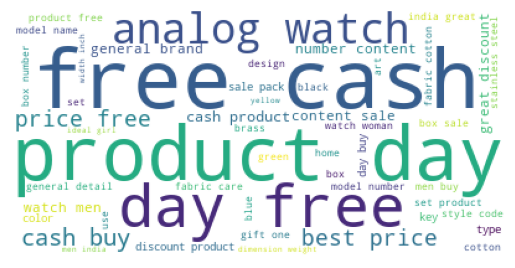

<IPython.core.display.Javascript object>

In [45]:
# Display the words
wordcloud = WordCloud(background_color="white", stopwords=[], max_words=50).generate(
    " ".join(corpus)
)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Home Furnishing


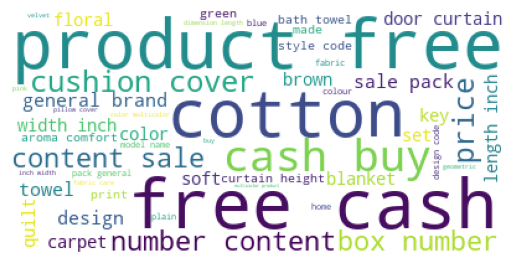


Baby Care


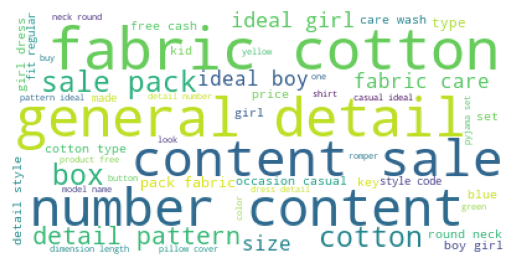


Watches


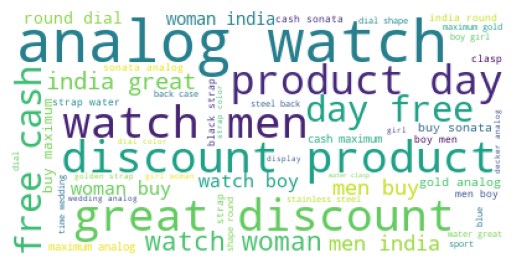


Home Decor & Festive Needs


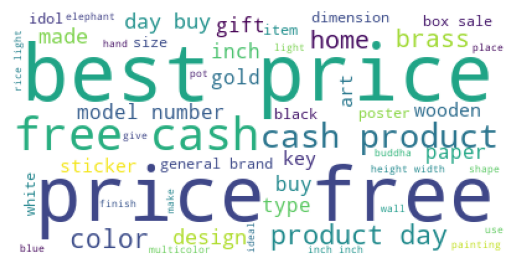


Kitchen & Dining


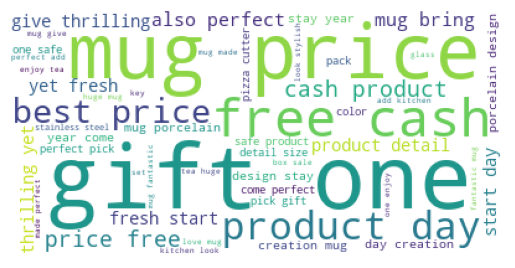


Beauty and Personal Care


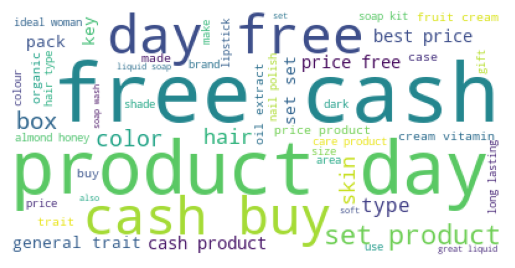


Computers


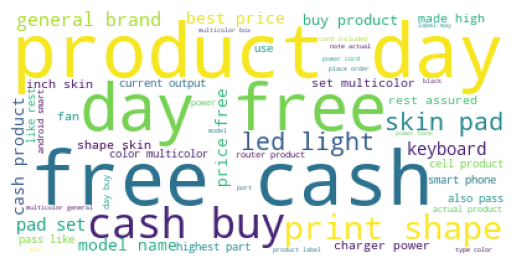

<IPython.core.display.Javascript object>

In [46]:
# Let's do the same process but for each prouct category
n = 20
list_freq_tokens = []
summary_cat = pd.DataFrame()

for cat in data_products["_product_category"].unique():
    print(cat)
    mask = data_products["_product_category"] == cat

    raw_corpus = " ".join(data_products.loc[mask, "description"].values)

    corpus = process_text(
        raw_corpus,
        rejoin=False,
        lemm_or_stemm="stem",
        list_rare_words=list_unique_words,
        min_len_word=3,
        force_is_alpha=True,
        eng_words=eng_words_stem,
        extra_words=None,
    )

    summary_cat[cat] = pd.Series(corpus).value_counts().head(n).index
    list_freq_tokens.extend(list(pd.Series(corpus).value_counts().head(n).index))

    wordcloud = WordCloud(
        background_color="white", stopwords=[], max_words=50
    ).generate(" ".join(corpus))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    print()

In [47]:
# Let's look at the most frequent tokens for each category
summary_cat

Home Furnishing Baby Care   Watches Home Decor & Festive Needs  \
0           cotton      girl     watch                      price   
1            cover    cotton    analog                    product   
2          product    detail       men                       best   
3             pack    fabric   product                        day   
4           design       boy       day                       inch   
5              buy     dress       buy                       free   
6             free     ideal     india                        buy   
7            towel   general     great                       wall   
8             cash      sale  discount                       home   
9          cushion      type      free                       cash   
10           color     color      cash                      color   
11            inch      neck     woman                      brass   
12            sale      wash      dial                     number   
13           price    number     strap                       gift   
14      multicolor   pattern       boy                        box   
15         curtain      pack     water                  dimension   
16           width   content     round                        art   
17         blanket     price    sonata                        key   
18          floral       box   maximum                      model   
19           brand   product      girl                     design   

   Kitchen & Dining Beauty and Personal Care   Computers  
0               mug                  product     product  
1           perfect                      set        free  
2             price                     free       power  
3           product                      day         day  
4            design                      buy         buy  
5              gift                     cash        cash  
6               one                    price        skin  
7               day                     skin       price  
8              safe                     hair       light  
9              give                      box     charger  
10             pack                     type       brand  
11             best                      oil       model  
12             come                    color       print  
13          kitchen                    trait        size  
14             free                     soap       shape  
15              buy                     pack        type  
16              tea                      lip         led  
17            pizza                    ideal         pad  
18            fresh                    cream  multicolor  
19             type                     care         key

<IPython.core.display.Javascript object>

In [48]:
# Look at the tokens existing in at least 5 categories
freq_words = pd.Series(list_freq_tokens).value_counts()
freq_words = freq_words[freq_words >= 5]
freq_words

product    7
price      6
buy        6
free       6
day        5
cash       5
dtype: int64

<IPython.core.display.Javascript object>

In [49]:
# create a list, we'll remove those tokens as they too frequent
freq_words = list(freq_words.index)
freq_words

['product', 'price', 'buy', 'free', 'day', 'cash']

<IPython.core.display.Javascript object>

In [50]:
# Final text process
corpus = process_text(
    raw_corpus,
    rejoin=False,
    lemm_or_stemm="stem",
    list_rare_words=list_unique_words,
    min_len_word=3,
    force_is_alpha=True,
    eng_words=eng_words_stem,
    extra_words=freq_words,
)
display_tokens_info(corpus)

nb tokens 3673, nb tokens uniques 465
['key', 'link', 'io', 'android', 'link', 'white', 'speed', 'wireless', 'speed', 'speed', 'general', 'brand', 'link', 'box', 'plug', 'model', 'type', 'color', 'white', 'type', 'repair', 'dimension', 'weight', 'number', 'antenna', 'number', 'port', 'antenna', 'protocol', 'standard']


<IPython.core.display.Javascript object>

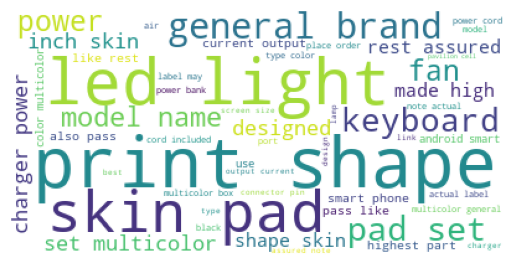

<IPython.core.display.Javascript object>

In [51]:
# display the tokens
wordcloud = WordCloud(background_color="white", stopwords=[], max_words=50).generate(
    " ".join(corpus)
)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [52]:
# Now apply this final process to each doc and store the result in a new feature
data_products["clean_text"] = data_products["description"].apply(final_clean)

<IPython.core.display.Javascript object>

# <a name="C4"> Clustering from text data
## <a name="C4.1"> Bag of Words - Tf-idf

In [136]:
# BOW model
cvect = CountVectorizer(max_df=0.85, min_df=0)
# Tf-idf model
ctf = TfidfVectorizer(max_df=0.85, min_df=0)

# feature to use to fit the models
feat = "clean_text"
cv_fit = cvect.fit(data_products[feat])
ctf_fit = ctf.fit(data_products[feat])

# create the matrix
cv_transform = cvect.transform(data_products[feat])
ctf_transform = ctf.transform(data_products[feat])

<IPython.core.display.Javascript object>

In [137]:
# Set up the number of clusters (=number of categories)
l_cat = list(set(data_products["_product_category"]))
print("catégories : ", l_cat)

# store the product category values for each line
y_cat_num = [
    (1 - l_cat.index(data_products.iloc[i]["_product_category"]))
    for i in range(len(data_products))
]

catégories :  ['Computers', 'Beauty and Personal Care', 'Home Decor & Festive Needs', 'Watches', 'Home Furnishing', 'Baby Care', 'Kitchen & Dining']


<IPython.core.display.Javascript object>

In [138]:
# PCA
X_reduced = pca_data(cv_transform.toarray())

Initial shape of data :  (1050, 1552)
Reduced data shape : (1050, 235)


<IPython.core.display.Javascript object>

In [139]:
# Calculate TSNE, clustering and ARI
print("CountVectorizer : ")
ARI, X_tsne, labels = ARI_fct(X_reduced)

CountVectorizer : 
ARI :  0.3771


<IPython.core.display.Javascript object>

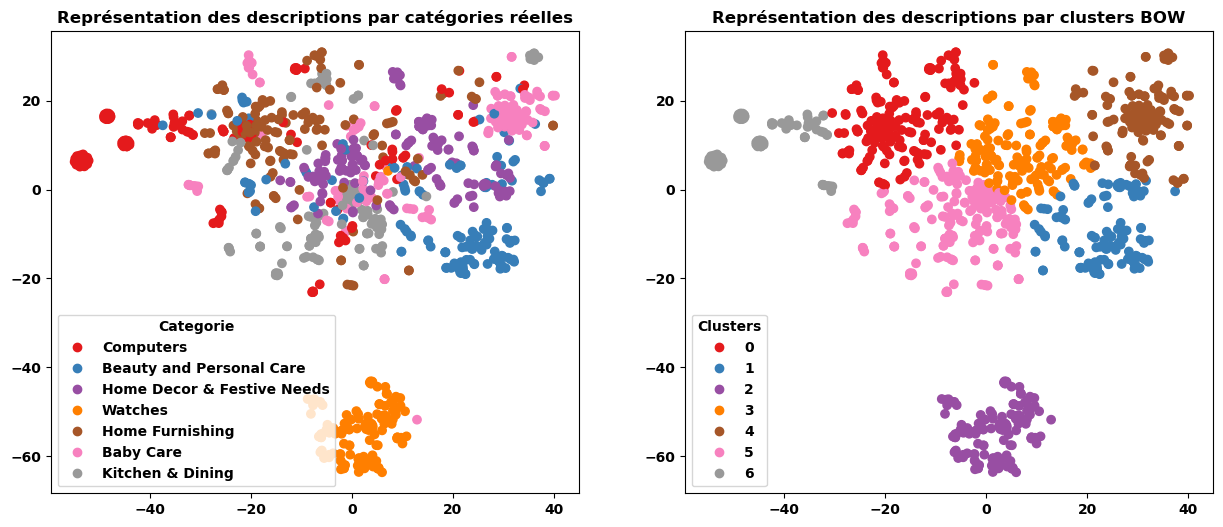

ARI :  0.3771


<IPython.core.display.Javascript object>

In [140]:
# Display the clusters VS real categories
method = "BOW"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [141]:
# PCA
X_reduced = pca_data(ctf_transform.toarray())

Initial shape of data :  (1050, 1552)
Reduced data shape : (1050, 426)


<IPython.core.display.Javascript object>

In [142]:
# Calculate TSNE, clustering and ARI
print("Tf-idf : ")
ARI, X_tsne, labels = ARI_fct(X_reduced)

Tf-idf : 
ARI :  0.2751


<IPython.core.display.Javascript object>

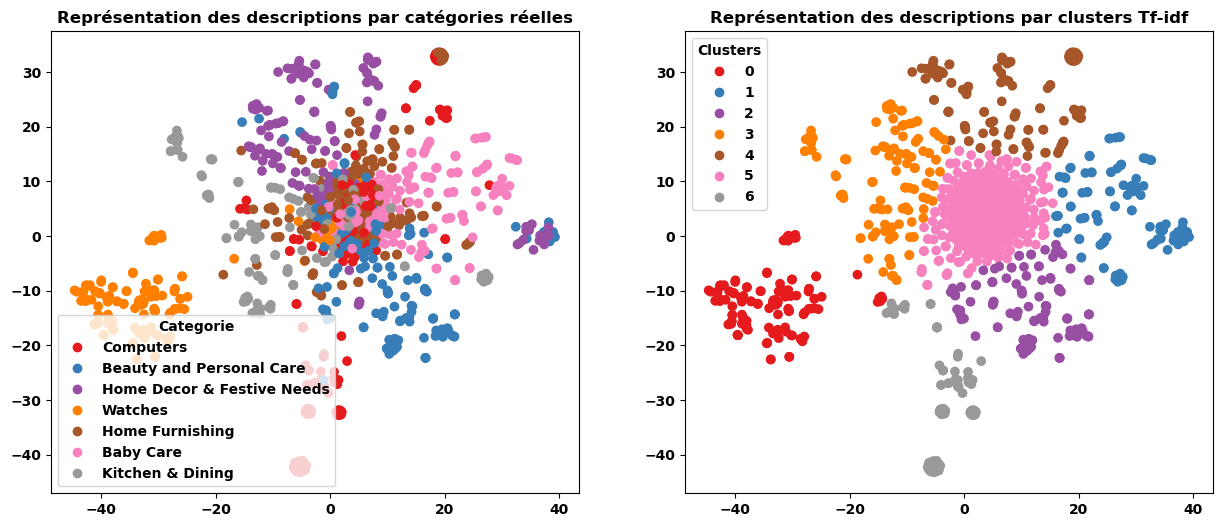

ARI :  0.2751


<IPython.core.display.Javascript object>

In [143]:
# Display the clusters VS real categories
method = "Tf-idf"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## <a name="C4.2"> Word2Vec

In [61]:
# settings for Word2Vec
w2v_size = 250
w2v_window = 6
w2v_min_count = 1
w2v_epochs = 100
maxlen = 25  # adapt to length of sentences
sentences = data_products["clean_text"].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

<IPython.core.display.Javascript object>

In [62]:
# Creation and training for Word2Vec model
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(
    min_count=w2v_min_count,
    window=w2v_window,
    vector_size=w2v_size,
    seed=random_set,
    workers=multiprocessing.cpu_count(),
)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 1552
Word2Vec trained


<IPython.core.display.Javascript object>

In [63]:
# Sentences preparation (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(
    tokenizer.texts_to_sequences(sentences), maxlen=maxlen, padding="post"
)

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 1553


<IPython.core.display.Javascript object>

In [64]:
# Create embedding matrix
print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j / i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (1553, 250)


<IPython.core.display.Javascript object>

In [65]:
# Create embedding model
input = Input(shape=(len(x_sentences), maxlen), dtype="float64")
word_input = Input(shape=(maxlen,), dtype="float64")
word_embedding = Embedding(
    input_dim=vocab_size,
    output_dim=w2v_size,
    weights=[embedding_matrix],
    input_length=maxlen,
)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding (Embedding)       (None, 25, 250)           388250    
                                                                 
 global_average_pooling1d (G  (None, 250)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 388,250
Trainable params: 388,250
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [66]:
# Run model
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 3ms/step


(1050, 250)

<IPython.core.display.Javascript object>

In [67]:
# PCA
X_reduced = pca_data(embeddings)

Initial shape of data :  (1050, 250)
Reduced data shape : (1050, 28)


<IPython.core.display.Javascript object>

In [68]:
# Calculate TSNE, clustering and ARI
ARI, X_tsne, labels = ARI_fct(X_reduced)

ARI :  0.3069


<IPython.core.display.Javascript object>

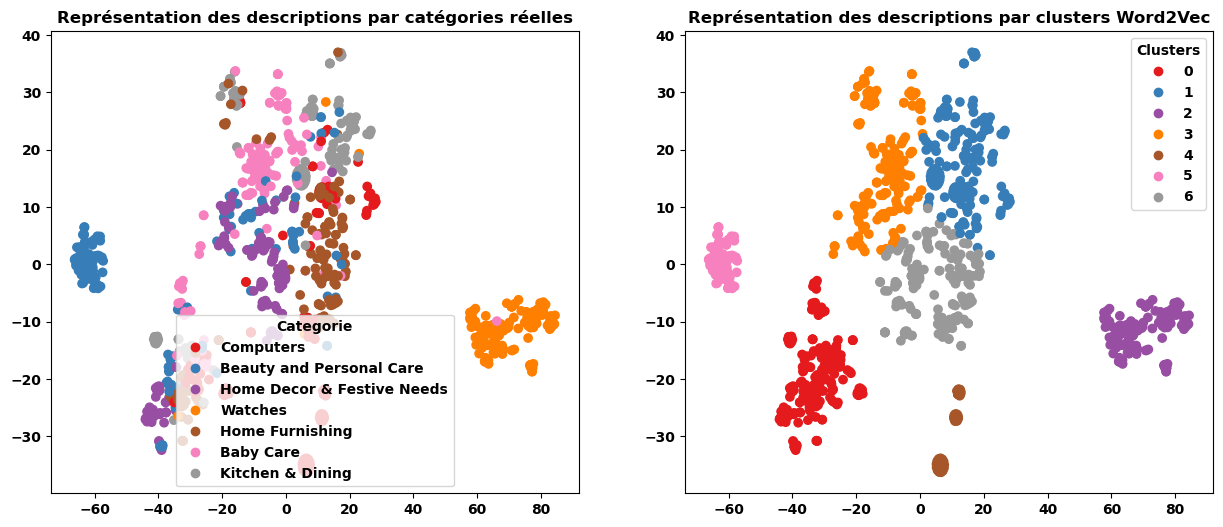

ARI :  0.3069


<IPython.core.display.Javascript object>

In [69]:
# Display the clusters VS real categories
method = "Word2Vec"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## <a name="C4.3"> BERT

### BERT HuggingFace

#### 'bert-base-uncased'

In [70]:
# BERT model settings
max_length = 40
batch_size = 10
model_type = "bert-base-uncased"
model = TFAutoModel.from_pretrained(model_type)
sentences = data_products["clean_text"].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<IPython.core.display.Javascript object>

In [71]:
# BERT features creation
features_bert = feature_BERT_fct(
    model, model_type, sentences, max_length, batch_size, mode="HF"
)

1/1 [==============================] - 1s 644ms/step


<IPython.core.display.Javascript object>

In [72]:
# PCA
X_reduced = pca_data(features_bert)

Initial shape of data :  (1050, 768)
Reduced data shape : (1050, 156)


<IPython.core.display.Javascript object>

In [73]:
# Calculate TSNE, clustering and ARI
ARI, X_tsne, labels = ARI_fct(X_reduced)

ARI :  0.2582


<IPython.core.display.Javascript object>

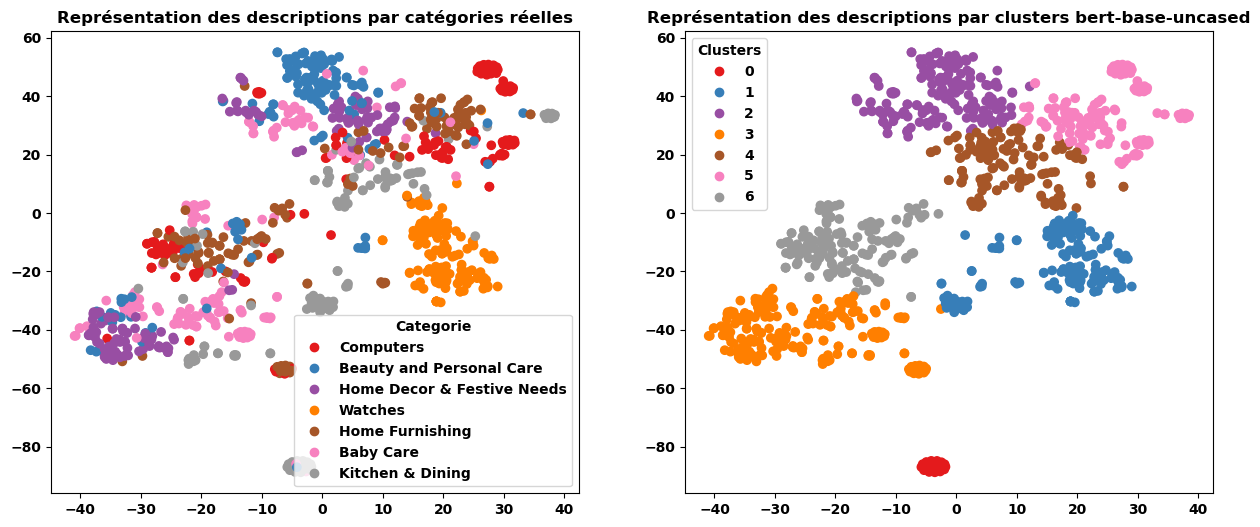

ARI :  0.2582


<IPython.core.display.Javascript object>

In [74]:
# Display the clusters VS real categories
method = model_type
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

#### bert-large-uncased

In [75]:
# BERT model settings
max_length = 40
batch_size = 10
model_type = "bert-large-uncased"
model = TFAutoModel.from_pretrained(model_type)
sentences = data_products["clean_text"].to_list()

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<IPython.core.display.Javascript object>

In [76]:
# BERT features creation
features_bert = feature_BERT_fct(
    model, model_type, sentences, max_length, batch_size, mode="HF"
)

1/1 [==============================] - 2s 2s/step


<IPython.core.display.Javascript object>

In [77]:
# PCA
X_reduced = pca_data(features_bert)

Initial shape of data :  (1050, 1024)
Reduced data shape : (1050, 171)


<IPython.core.display.Javascript object>

In [78]:
# Calculate TSNE, clustering and ARI
ARI, X_tsne, labels = ARI_fct(X_reduced)

ARI :  0.2846


<IPython.core.display.Javascript object>

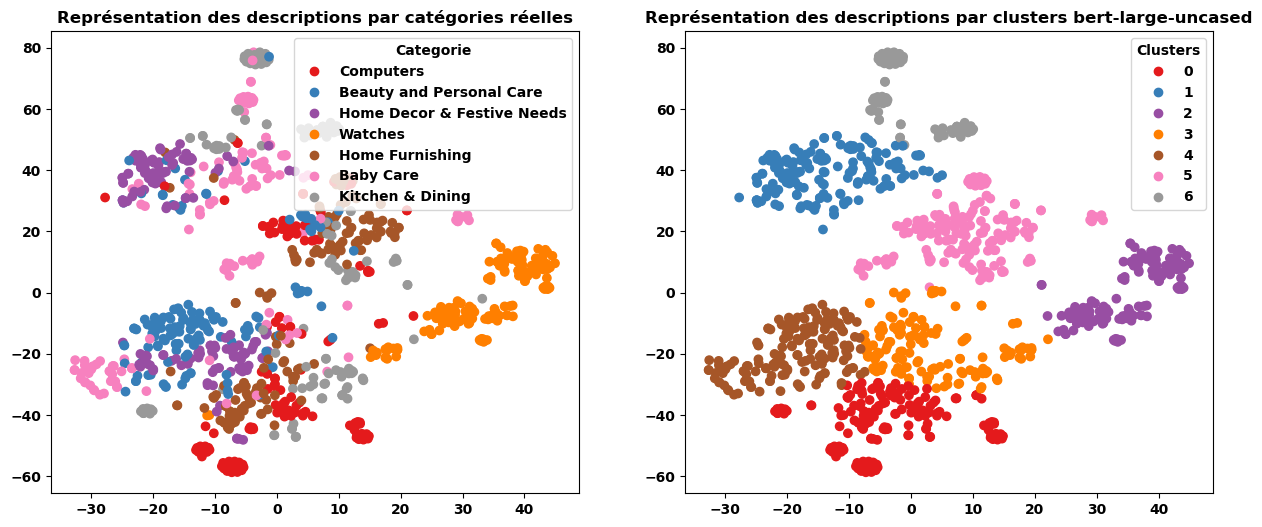

ARI :  0.2846


<IPython.core.display.Javascript object>

In [79]:
# Display the clusters VS real categories
method = model_type
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### BERT Tensorflow hub

In [80]:
# Tensorflow hub model
model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_layer = hub.KerasLayer(model_url, trainable=True)

<IPython.core.display.Javascript object>

In [81]:
# create the list of sentences
sentences = data_products["clean_text"].to_list()

<IPython.core.display.Javascript object>

In [82]:
# settings for the model
max_length = 40
batch_size = 10
model_type = "bert-base-uncased"
model = bert_layer

features_bert = feature_BERT_fct(
    model, model_type, sentences, max_length, batch_size, mode="TFhub"
)

<IPython.core.display.Javascript object>

In [83]:
# PCA
X_reduced = pca_data(features_bert)

Initial shape of data :  (1050, 768)
Reduced data shape : (1050, 157)


<IPython.core.display.Javascript object>

In [84]:
# Calculate TSNE, clustering and ARI
ARI, X_tsne, labels = ARI_fct(X_reduced)

ARI :  0.2835


<IPython.core.display.Javascript object>

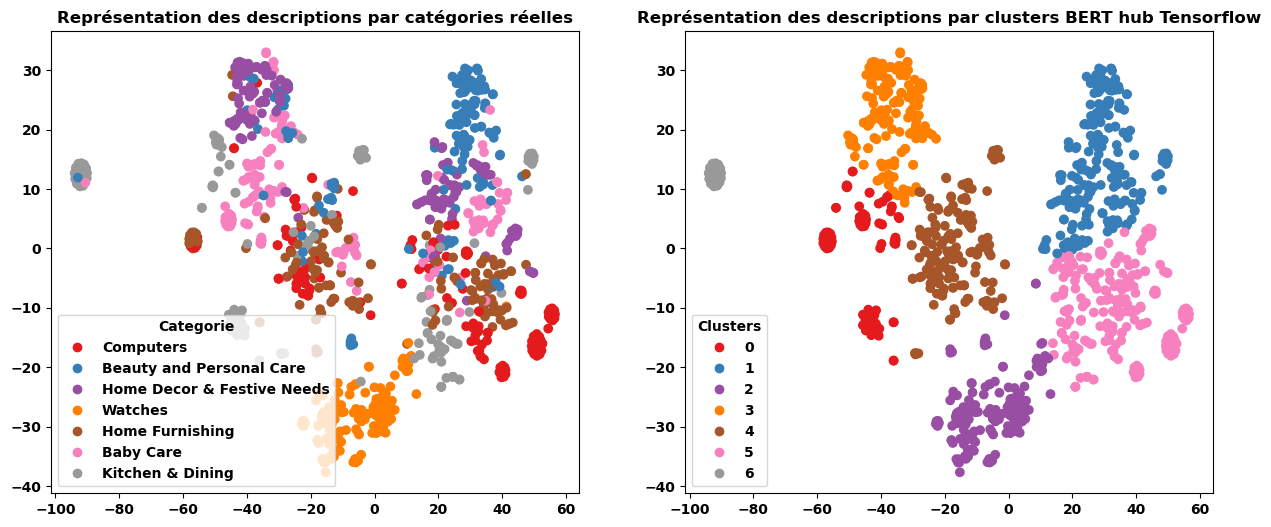

ARI :  0.2835


<IPython.core.display.Javascript object>

In [85]:
# Display the clusters VS real categories
method = "BERT hub Tensorflow"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## <a name="C4.4"> USE - Universal Sentence Encoder

In [86]:
# Load USE model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

<IPython.core.display.Javascript object>

In [87]:
# model settings
batch_size = 15
sentences = data_products["clean_text"].to_list()

<IPython.core.display.Javascript object>

In [88]:
# features creation
features_USE = feature_USE_fct(sentences, batch_size)

<IPython.core.display.Javascript object>

In [89]:
# PCA
X_reduced = pca_data(features_USE)

Initial shape of data :  (1050, 512)
Reduced data shape : (1050, 183)


<IPython.core.display.Javascript object>

In [90]:
# Calculate TSNE, clustering and ARI
ARI, X_tsne, labels = ARI_fct(X_reduced)

ARI :  0.3352


<IPython.core.display.Javascript object>

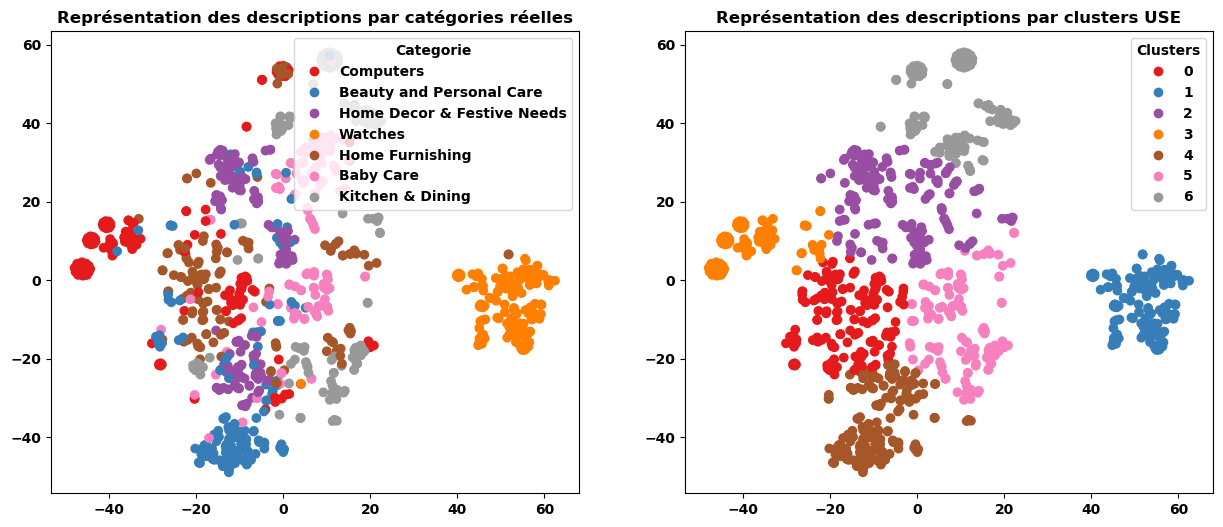

ARI :  0.3352


<IPython.core.display.Javascript object>

In [91]:
# Display the clusters VS real categories
method = "USE"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# <a name="C5"> Clustering from images

## <a name="C5.1"> Settings and data preparation

In [92]:
# Directory where the pictures are stored
path = "C:/Users/bruno/kDrive/Work/OpenClassrooms/P6/Flipkart/Images/"

# Image dimensions
dim = (224, 224)

# initiate sift
sift = cv2.xfeatures2d.SIFT_create()

# sift descriptors output size
size = 35

<IPython.core.display.Javascript object>

## <a name="C5.2"> SIFT

Category :  Computers
img 1 :  519
img 2 :  35


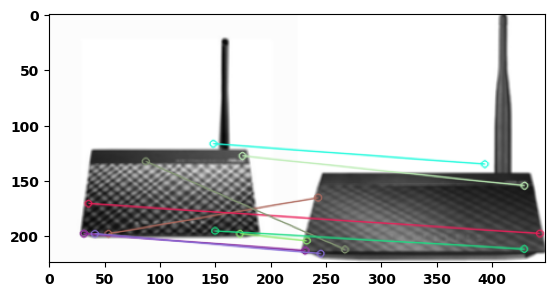

Category :  Beauty and Personal Care
img 1 :  158
img 2 :  372


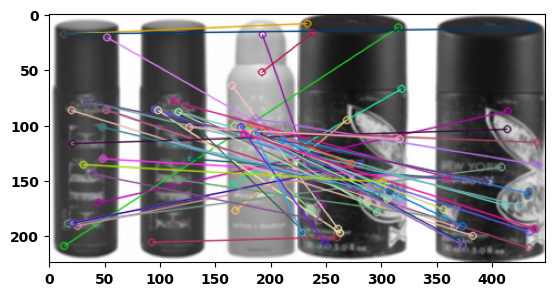

Category :  Home Decor & Festive Needs
img 1 :  831
img 2 :  216


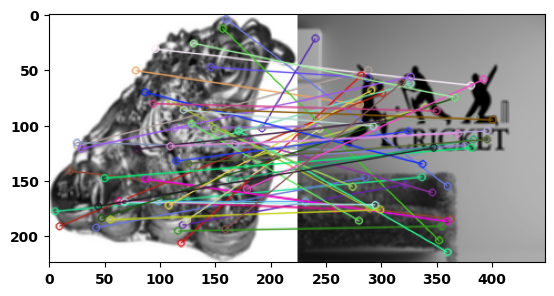

Category :  Watches
img 1 :  655
img 2 :  179


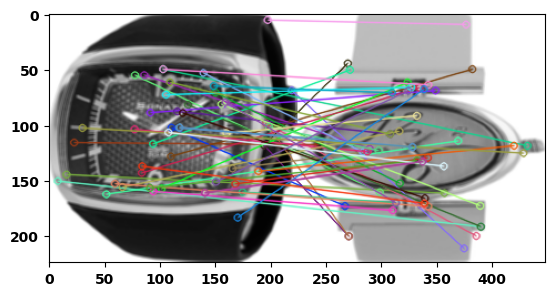

Category :  Home Furnishing
img 1 :  89
img 2 :  705


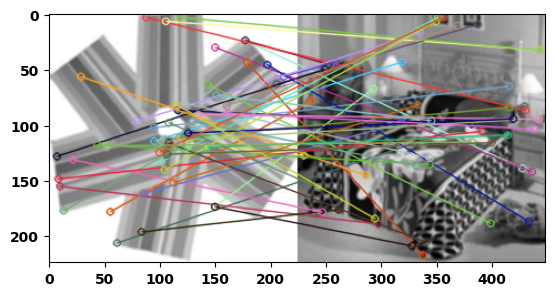

Category :  Baby Care
img 1 :  1046
img 2 :  755


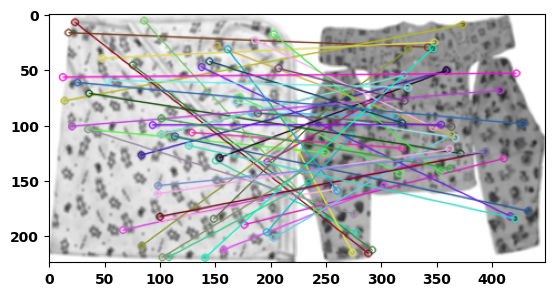

Category :  Kitchen & Dining
img 1 :  244
img 2 :  227


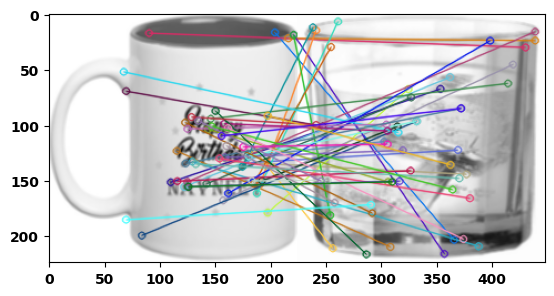

<IPython.core.display.Javascript object>

In [93]:
# look at some examples compare 2 random images in each category
for cat in l_cat:
    print("Category : ", cat)

    # Pick up 2 random samples of the data for the category
    data_sample = data_products[data_products["_product_category"] == cat].sample(2)

    # extract the names of the picture files
    image_name_1 = str(data_sample.image.values[0])
    image_name_2 = str(data_sample.image.values[1])

    # load the pictures
    img1 = cv2.imread(path + image_name_1)
    img2 = cv2.imread(path + image_name_2)

    # Resize the pictures so they have the same size
    img1 = cv2.resize(img1, dim, interpolation=cv2.INTER_AREA)
    img2 = cv2.resize(img2, dim, interpolation=cv2.INTER_AREA)

    # noise reduction
    img1 = cv2.GaussianBlur(img1, (3, 3), cv2.BORDER_DEFAULT)
    img2 = cv2.GaussianBlur(img2, (3, 3), cv2.BORDER_DEFAULT)

    # Tranform the pictures to grey
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # create the keypoints and descriptors
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

    print("img 1 : ", len(keypoints_1))
    print("img 2 : ", len(keypoints_2))

    # feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key=lambda x: x.distance)

    # display the 2 images and their matches
    img3 = cv2.drawMatches(
        img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2
    )
    plt.imshow(img3), plt.show()

In [94]:
# Apply our fonction to transform the images and find their descriptors as our features
data_products["sift_features"] = data_products["image"].apply(features_sift)
data_products.head(5)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0    1,899.0000          899.0000  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1      600.0000          449.0000  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3    2,699.0000        1,299.0000  d4684dcdc759dd9cdf41504698d737d8.jpg   
4    2,599.0000          698.0000  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications _product_category  \
0  {"product_specification"=>[{"key"=>"Brand", "v...   Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...         Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...         Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...   Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...   Home Furnishing   

                                          clean_text  \
0  key multicolor abstract eyelet door curtain fl...   
1  cotton bath towel bath towel red yellow blue b...   
2  key cotton face towel set size small height in...   
3  key royal fashion cotton king royal wedding ro...   
4  key print cotton floral king cotton print cott...   

                                       sift_features  
0  [[0.0, 0.0, 41.0, 61.0, 4.0, 1.0, 1.0, 0.0, 0....  
1  [[1.0, 1.0, 0.0, 7.0, 49.0, 26.0, 9.0, 0.0, 14...  
2  [[2.0, 1.0, 0.0, 1.0, 23.0, 28.0, 15.0, 7.0, 7...  
3  [[60.0, 6.0, 9.0, 23.0, 22.0, 28.0, 35.0, 108....  
4  [[4.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0,...

<IPython.core.display.Javascript object>

In [95]:
# some images does not have the required number of descriptors so sift_features is empty
data_sift = data_products[["sift_features", "_product_category"]]
data_sift.describe()

sift_features _product_category
count                                                1011              1050
unique                                               1011                 7
top     [[0.0, 0.0, 41.0, 61.0, 4.0, 1.0, 1.0, 0.0, 0....   Home Furnishing
freq                                                    1               150

<IPython.core.display.Javascript object>

In [96]:
# let's remove empty features
data_sift = data_sift.dropna()
data_sift

sift_features _product_category
0     [[0.0, 0.0, 41.0, 61.0, 4.0, 1.0, 1.0, 0.0, 0....   Home Furnishing
1     [[1.0, 1.0, 0.0, 7.0, 49.0, 26.0, 9.0, 0.0, 14...         Baby Care
2     [[2.0, 1.0, 0.0, 1.0, 23.0, 28.0, 15.0, 7.0, 7...         Baby Care
3     [[60.0, 6.0, 9.0, 23.0, 22.0, 28.0, 35.0, 108....   Home Furnishing
4     [[4.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0,...   Home Furnishing
...                                                 ...               ...
1045  [[24.0, 18.0, 11.0, 46.0, 20.0, 2.0, 3.0, 6.0,...         Baby Care
1046  [[15.0, 5.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 6.0...         Baby Care
1047  [[49.0, 152.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1...         Baby Care
1048  [[127.0, 49.0, 31.0, 26.0, 0.0, 0.0, 0.0, 0.0,...         Baby Care
1049  [[0.0, 2.0, 18.0, 13.0, 0.0, 0.0, 0.0, 0.0, 4....         Baby Care

[1011 rows x 2 columns]

<IPython.core.display.Javascript object>

In [97]:
# store values for the real categories
y_cat_num = [
    (1 - l_cat.index(data_sift.iloc[i]["_product_category"]))
    for i in range(len(data_sift))
]
print(len(y_cat_num))

# format the features data
sift_features = np.asarray(data_sift["sift_features"])
sift_features = np.stack(sift_features, axis=0)
print(sift_features.shape)

1011
(1011, 35, 128)


<IPython.core.display.Javascript object>

In [98]:
# format to 2D matrix
nsamples, nx, ny = sift_features.shape
sift = sift_features.reshape((nsamples, nx * ny))

<IPython.core.display.Javascript object>

In [99]:
# PCA
X_reduced = pca_data(sift)

Initial shape of data :  (1011, 4480)
Reduced data shape : (1011, 720)


<IPython.core.display.Javascript object>

In [100]:
# Calculate TSNE, clustering and ARI
ARI, X_tsne, labels = ARI_fct(X_reduced)

ARI :  0.0171


<IPython.core.display.Javascript object>

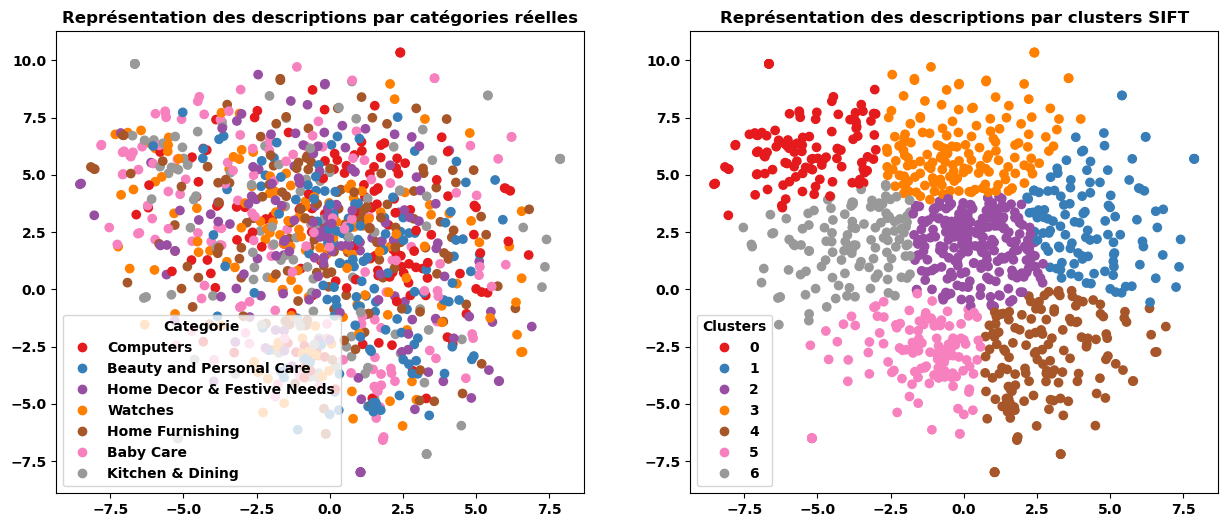

ARI :  0.0171


<IPython.core.display.Javascript object>

In [101]:
# Display the clusters VS real categories
method = "SIFT"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## <a name="C5.3"> CNN

### Clustering with resnet50

In [129]:
# Prepare the data
X = np.asarray(data_products["image"].apply(prepare_image))
X = np.stack(X)
print(X.shape)

C:\Users\bruno\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)


<IPython.core.display.Javascript object>

In [130]:
# Initiate the model
MyModel = tf.keras.models.Sequential()
MyModel.add(
    tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        pooling="avg",
    )
)

<IPython.core.display.Javascript object>

In [131]:
# features creation
extractedFeatures = MyModel.predict(X)

33/33 [==============================] - 45s 1s/step


<IPython.core.display.Javascript object>

In [132]:
# format the features
extractedFeatures = np.array(extractedFeatures)

<IPython.core.display.Javascript object>

In [133]:
# PCA
X_reduced = pca_data(extractedFeatures)

Initial shape of data :  (1050, 2048)
Reduced data shape : (1050, 414)


<IPython.core.display.Javascript object>

In [134]:
# Store the values for the real categories
y_cat_num = [
    (1 - l_cat.index(data_products.iloc[i]["_product_category"]))
    for i in range(len(data_products))
]
# Calculate TSNE, clustering and ARI
ARI, X_tsne, labels = ARI_fct(X_reduced)

ARI :  0.5073


<IPython.core.display.Javascript object>

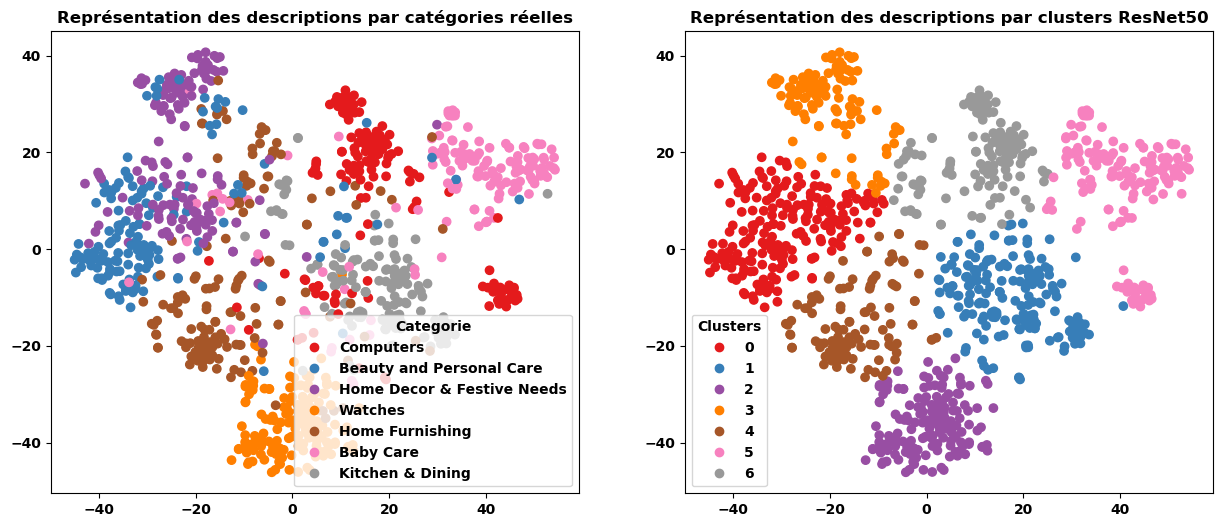

ARI :  0.5073


<IPython.core.display.Javascript object>

In [135]:
# Display the clusters VS real categories
method = "ResNet50"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Clustering with VGG16

In [109]:
# Load VGG-16 pre-trained model without fully-connected layer
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# features creation
extractedFeatures = np.array(model.predict(X))

33/33 [==============================] - 187s 6s/step


<IPython.core.display.Javascript object>

In [110]:
# format the features
nsamples, nx, ny, nz = extractedFeatures.shape
vgg16 = extractedFeatures.reshape((nsamples, nx * ny * nz))
vgg16.shape

(1050, 25088)

<IPython.core.display.Javascript object>

In [111]:
# PCA
X_reduced = pca_data(vgg16)

Initial shape of data :  (1050, 25088)
Reduced data shape : (1050, 754)


<IPython.core.display.Javascript object>

In [112]:
# Store the values for the real categories
y_cat_num = [
    (1 - l_cat.index(data_products.iloc[i]["_product_category"]))
    for i in range(len(data_products))
]
# Calculate TSNE, clustering and ARI
ARI, X_tsne, labels = ARI_fct(X_reduced)

ARI :  0.2937


<IPython.core.display.Javascript object>

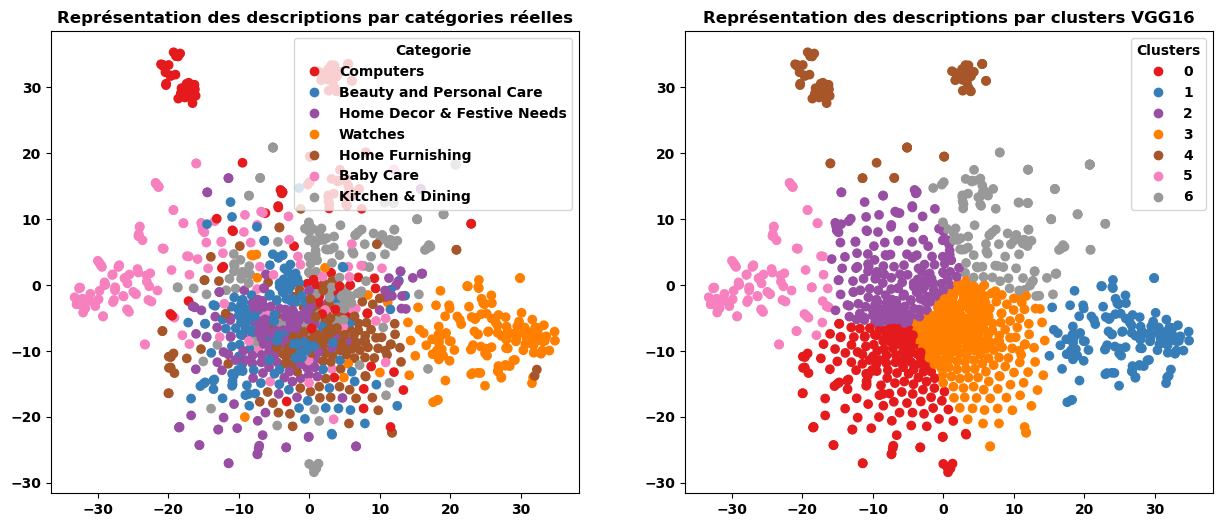

ARI :  0.2937


<IPython.core.display.Javascript object>

In [113]:
# Display the clusters VS real categories
method = "VGG16"
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# <a name="C6"> Classification engine

## ResNet50

In [114]:
# Prepare the data to train the model and evaluate it

# Create a matrix with the real categories
y = np.asarray(pd.get_dummies(data_products["_product_category"], prefix="_categ"))

# Split X and y with train and test data sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=random_set
)

<IPython.core.display.Javascript object>

In [115]:
print(X_train.shape)
print(y_train.shape)

(682, 224, 224, 3)
(682, 7)


<IPython.core.display.Javascript object>

In [116]:
# Load ResNet50 pre-trained model without fully-connected layer
model = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", pooling="avg", input_shape=(224, 224, 3)
)

# get output from this network
x = model.output
x = Flatten()(x)

# Add the new fully-connected layer for the classification
predictions = Dense(len(l_cat), activation="softmax")(x)

# Define the new model
new_model = Model(inputs=model.input, outputs=predictions)

<IPython.core.display.Javascript object>

In [117]:
# Do not train the N first layers (lowest ones)
for layer in model.layers[:165]:
    layer.trainable = False

<IPython.core.display.Javascript object>

In [118]:
# Make sure we have frozen the relevant layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_5 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

<IPython.core.display.Javascript object>

In [119]:
# model settings
epochs = 25

# Compile the model
new_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
    metrics=["accuracy"],
)

# Train the model (X_train, y_train)
model_info = new_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2
)

Epoch 1/25
46/46 - 63s - loss: 1.9687 - accuracy: 0.3079 - 63s/epoch - 1s/step
Epoch 2/25
46/46 - 57s - loss: 1.2201 - accuracy: 0.6056 - 57s/epoch - 1s/step
Epoch 3/25
46/46 - 56s - loss: 0.9075 - accuracy: 0.7199 - 56s/epoch - 1s/step
Epoch 4/25
46/46 - 57s - loss: 0.7508 - accuracy: 0.7830 - 57s/epoch - 1s/step
Epoch 5/25
46/46 - 60s - loss: 0.6387 - accuracy: 0.8167 - 60s/epoch - 1s/step
Epoch 6/25
46/46 - 55s - loss: 0.5725 - accuracy: 0.8387 - 55s/epoch - 1s/step
Epoch 7/25
46/46 - 58s - loss: 0.5116 - accuracy: 0.8548 - 58s/epoch - 1s/step
Epoch 8/25
46/46 - 62s - loss: 0.4703 - accuracy: 0.8666 - 62s/epoch - 1s/step
Epoch 9/25
46/46 - 60s - loss: 0.4290 - accuracy: 0.8783 - 60s/epoch - 1s/step
Epoch 10/25
46/46 - 63s - loss: 0.3985 - accuracy: 0.8900 - 63s/epoch - 1s/step
Epoch 11/25
46/46 - 60s - loss: 0.3729 - accuracy: 0.9032 - 60s/epoch - 1s/step
Epoch 12/25
46/46 - 58s - loss: 0.3451 - accuracy: 0.9106 - 58s/epoch - 1s/step
Epoch 13/25
46/46 - 55s - loss: 0.3288 - accuracy

<IPython.core.display.Javascript object>

In [120]:
# Evaluate the model
new_model.evaluate(X_test, y_test)

12/12 [==============================] - 24s 2s/step - loss: 0.5069 - accuracy: 0.8152


[0.50690096616745, 0.8152173757553101]

<IPython.core.display.Javascript object>

In [121]:
# End of processes
end = datetime.datetime.now()
print("start :", start.strftime("%Y-%m-%d %H:%M:%S"))
print("end :", end.strftime("%Y-%m-%d %H:%M:%S"))

start : 2022-11-23 08:04:50
end : 2022-11-23 09:00:23


<IPython.core.display.Javascript object>